In [16]:
import exploration.option_trades as rvol
import datetime
import pandas as pd

from exploration.curve_trades import on_the_run
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from ipywidgets import widgets

In [17]:
w = widgets.Dropdown(
    options=['IG', 'HY'],
    value='IG',
    description='Index:',
    disabled=False,
)
w

In [18]:
index = w.value
start_date=datetime.date(2014, 6, 11)
onTR, model = rvol.realized_vol(index, on_the_run('IG'), "5yr", years=3)

In [19]:
#onTR.plot()

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          spread_return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                34.5073
Distribution:                  Normal   AIC:                          -61.0146
Method:            Maximum Likelihood   BIC:                          -52.5061
                                        No. Observations:                   62
Date:                Thu, Dec 21 2017   Df Residuals:                       58
Time:                        14:17:36   Df Model:                            4
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0279  1.758e-02     -1.587      0.113 [-6.236e-02,6.557e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3703e-03  1.681e-03      0.815      0.415 [-1.924e-03,4.665e-03]
alpha[1]   9.1408e-14  8.012e-03  1.141e-11      1.000 [-1.570e-02,1.570e-02]
beta[1]        0.9310  9.562e-02      9.737  2.098e-22      [  0.744,  1.118]
=============================================================================

Covariance estimator: robust
"""

In [21]:
#compute lo and hi percentiles of atm volatility daily change (vol of vol)
rvol.vol_var()

/home/edwin/projects/code/python/yieldcurve.py:54: RuntimeWarning: cache miss for date: 2017-12-21
  RuntimeWarning)


1m        2m        3m
0.025 -0.058402 -0.042662 -0.037079
0.975  0.056015  0.042449  0.035047

In [28]:
df = rvol.atm_vol(index, start_date, moneyness = .2)
df['steepness'] = df.otm_vol - df.atm_vol
df1 = df.reset_index()
df1['date'] = df1.quotedate.dt.date
df1 = df1.groupby(['date','expiry']).last()
#Need to do: the vol looks jumpy, is it because of quote source issue? yes, need to first try to get the same quote source...

<IPython.core.display.Javascript object>


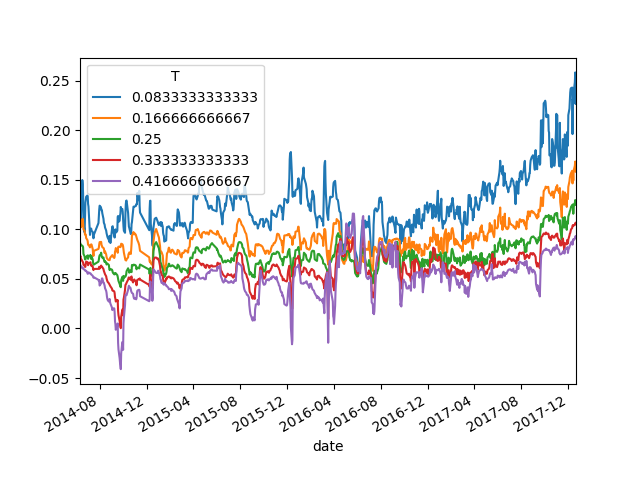

In [31]:
r = []
time = [1/12, 2/12, 3/12, 4/12, 5/12]
for t in time:
    for date, g in df1.groupby(level='date'):
        f = interp1d(g['T'].values, g['steepness'].values, fill_value='extrapolate')
        r.append((date, t, f(t)))
steepness = pd.DataFrame(r, columns=['date', 'T', 'steepness'])
steepness = steepness.set_index(['date','T']).unstack().astype('float')
steepness.columns = steepness.columns.droplevel()
steepness.ewm(span = 3).mean().plot()

In [32]:
(steepness.iloc[-1] - steepness.mean()) / steepness.std()

T
0.083333    4.179405
0.166667    3.624137
0.250000    3.392283
0.333333    2.487193
0.416667    1.760266
dtype: float64

In [ ]:
#Need to do: look at steepness not on moneyness but on delta range (60 delta vs 20 delta)